# Dogs and Cats Preprocessing

This notebook is the extraction, preprocessing and storing of the dogs and cats dataset (cats and dogs but I prefer dogs and cats)

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-07-06 13:08:46--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 64.233.182.128, 64.233.183.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.2’

cats_and_dogs_filte 100%[===================>]  65.43M   132MB/s    in 0.5s    

2023-07-06 13:08:47 (132 MB/s) - ‘cats_and_dogs_filtered.zip.2’ saved [68606236/68606236]



In [2]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
!ls -al cats_and_dogs_filtered

total 20
drwxr-x--- 4 root root 4096 Jul  6 13:08 .
drwxr-xr-x 6 root root 4096 Jul  6 13:08 ..
drwxr-x--- 4 root root 4096 Jul  6 13:08 train
drwxr-x--- 4 root root 4096 Jul  6 13:08 validation
-rw-r----- 1 root root  140 Jul  6 13:08 vectorize.py


Note that we can load everything into memory. This makes preprocessing much easier.

In [4]:
!du -sh cats_and_dogs_filtered

72M	cats_and_dogs_filtered


In [5]:
import os
input_dir = 'cats_and_dogs_filtered'

In [6]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
])

In [7]:
from PIL import Image
import torch
tensors = []
names = []
for dir in [input_dir + '/' + folder for folder in ['train/cats', 'train/dogs', 'validation/cats', 'validation/dogs']]:
  for filename in os.listdir(dir):
        try:
            img = Image.open(os.path.join(dir, filename))
            tensor = transform(img)
            tensors.append(tensor)
            names.append(0 if '/dogs' in dir else 1)
        except Exception as e:
            print(f"{filename}. Error: {e}")

tensors_stacked = torch.stack(tensors)
mean = torch.mean(tensors_stacked, [0, 2, 3])
std = torch.std(tensors_stacked, [0, 2, 3])
mean, std


(tensor([0.4868, 0.4533, 0.4155]), tensor([0.2546, 0.2474, 0.2499]))

In [8]:
tensors_normalized = (tensors_stacked - mean[:, None, None]) / std[:, None, None]

In [9]:
def denormalize_tensor(tensor):
  for t, m, s in zip(tensor, mean, std):
      t.mul_(s).add_(m)
  return tensor

In [10]:
from torch.utils.data import Dataset
class DogCatDataset(Dataset):
    def __init__(self, images, names):
        self.images = images
        self.names = names

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx], 'dog' if self.names[idx] == 0 else 'cat'

In [11]:
from torch.utils.data import DataLoader
data = DogCatDataset(tensors_normalized, names)
data_loader = DataLoader(data, batch_size=32, shuffle=True)

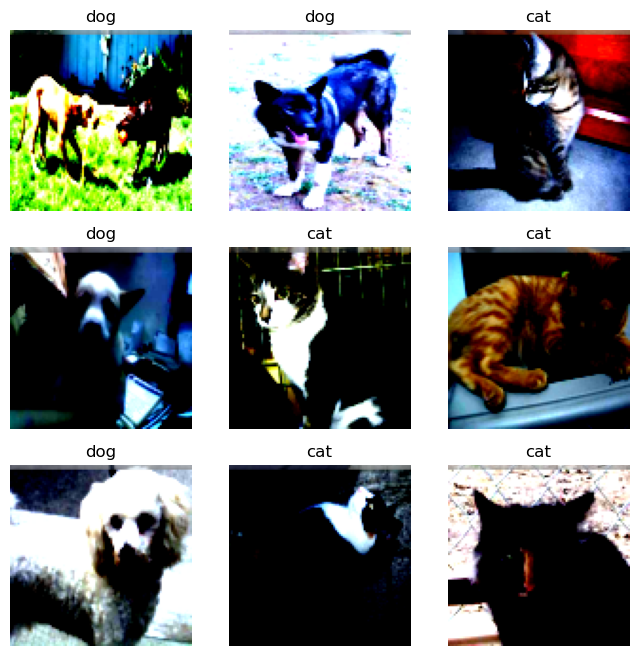

In [12]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(denormalize_tensor(img.permute(1, 2, 0)).numpy().clip(0, 1))
plt.show()

Now we can start modeling! We will use a standard VAE with Resnet18.

In [13]:
!pip install pytorch-lightning
!pip install lightning-bolts


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 6.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 33.1 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.0.3
    Uninstalling pytorch-lightning-2.0.3:
      Successfully uninstalled pytorch-lightning-2.0.3


In [14]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)


class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = vae.decoder(z)

        # reconstruction loss
        # percep_loss = nn.MSELoss()(self.vgg(x_hat), self.vgg(x))
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        a,b,c = (1, 1, 5)
        elbo = (a * kl - (b * recon_loss))
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
        })

        return elbo

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [15]:
from pl_bolts.datamodules import CIFAR10DataModule, ImagenetDataModule
# tried dogs and cats (even with vgg perceptual loss), will revisit
cifar_10 = CIFAR10DataModule('.')

In [22]:
pl.seed_everything(1234)

vae = VAE()
trainer = pl.Trainer(max_epochs=10, accelerator="gpu")
trainer.fit(vae, cifar_10)

/tmp/ipykernel_29/64861148.py:17: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/autoencoders/components.py:236: UnderRev

Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:217: UserWarning: strategy=ddp_spawn and num_workers=0 may result in data loading bottlenecks. Consider setting num_workers>0 and persistent_workers=True
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

[W reducer.cpp:1300] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1300] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

In [25]:
trainer = pl.Trainer(max_epochs=10, accelerator="gpu")
trainer.fit(vae, cifar_10)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


Files already downloaded and verified
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:217: UserWarning: strategy=ddp_spawn and num_workers=0 may result in data loading bottlenecks. Consider setting num_workers>0 and persistent_workers=True
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

[W reducer.cpp:1300] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later iterations to have unused parameters. (function operator())
[W reducer.cpp:1300] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward pass, consider turning this flag off. Note that this warning may be a false positive if your model has flow control causing later 

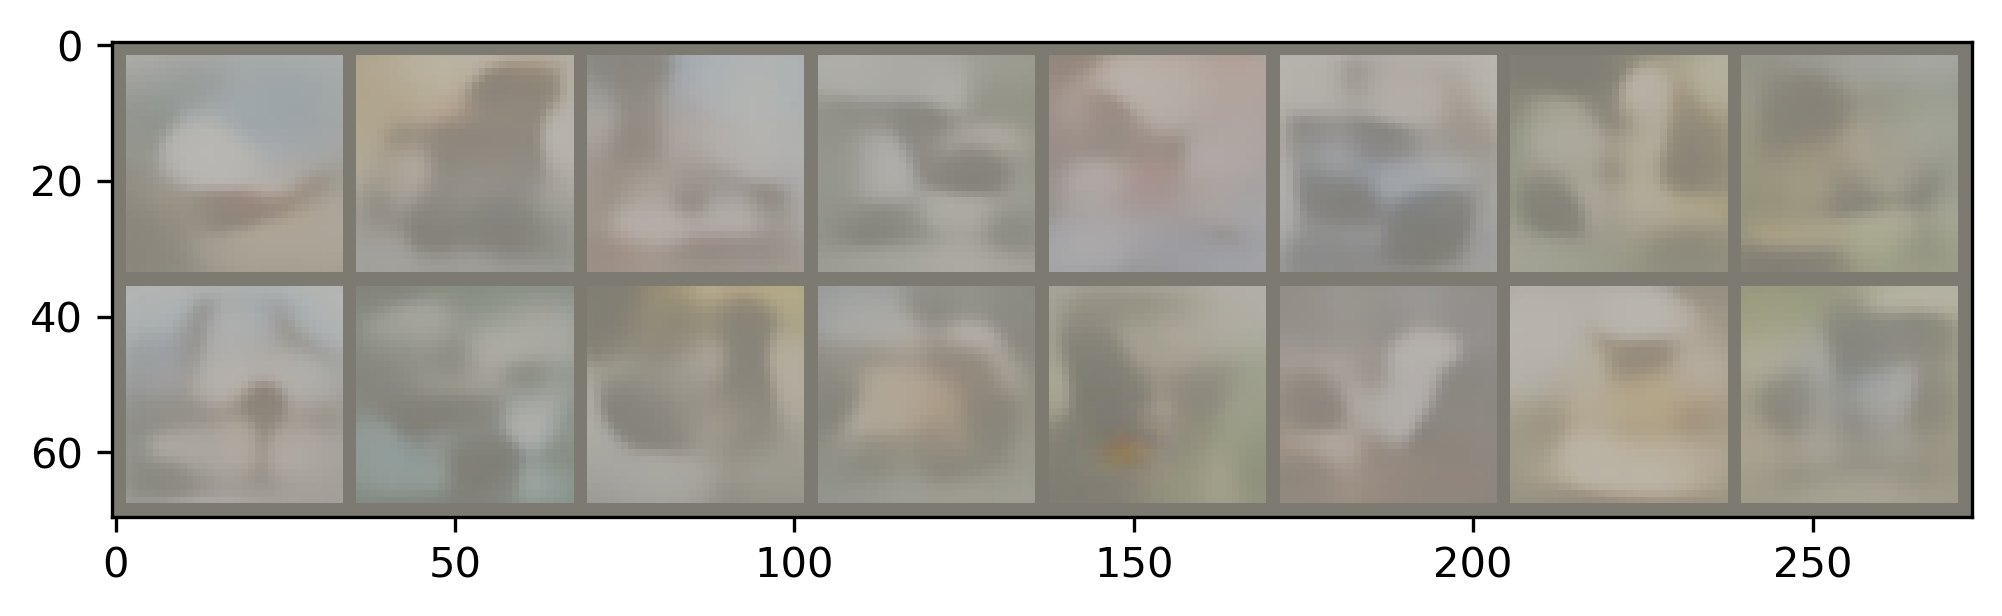

In [27]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

# Z COMES FROM NORMAL(0, 1)
num_preds = 16
p = torch.distributions.Normal(torch.zeros(256), torch.ones(256))
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

# PLOT IMAGES
imshow(img);

# decent performance

In [1]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs
